In [27]:
%matplotlib inline

from meshmaker.plt import *
from meshmaker.vec3 import vec3
from meshmaker.quat import quat
from meshmaker.planargraph import planargraph
from meshmaker.img import normalize, perlin
from meshmaker.field import vec3_field
from meshmaker.geometry import slide, sintsxyp
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import cv2

100%|██████████| 500/500 [00:11<00:00, 44.45it/s] 


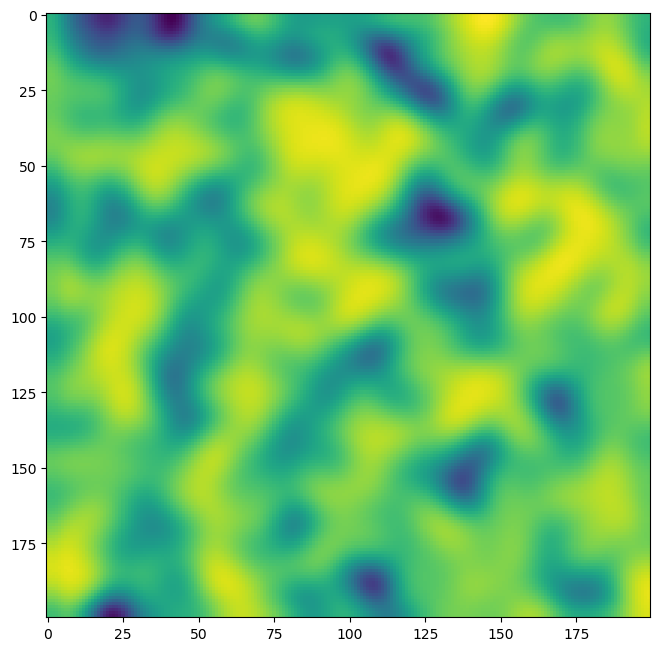

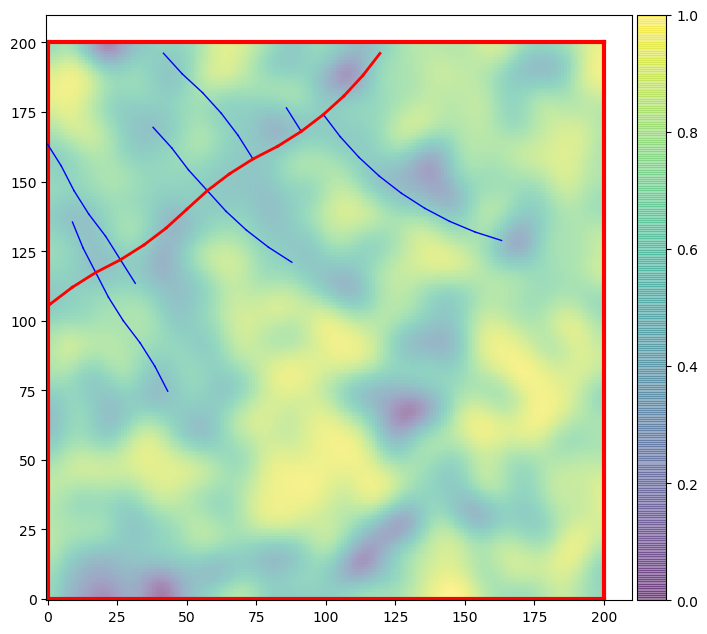

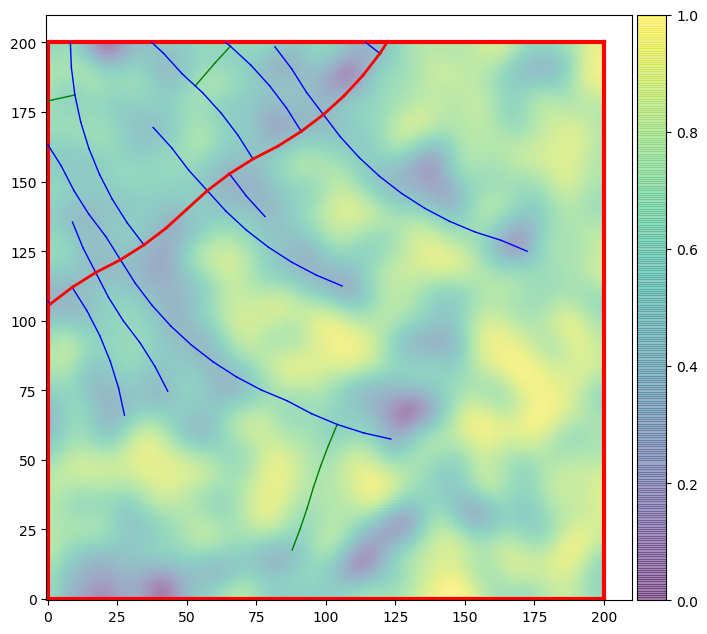

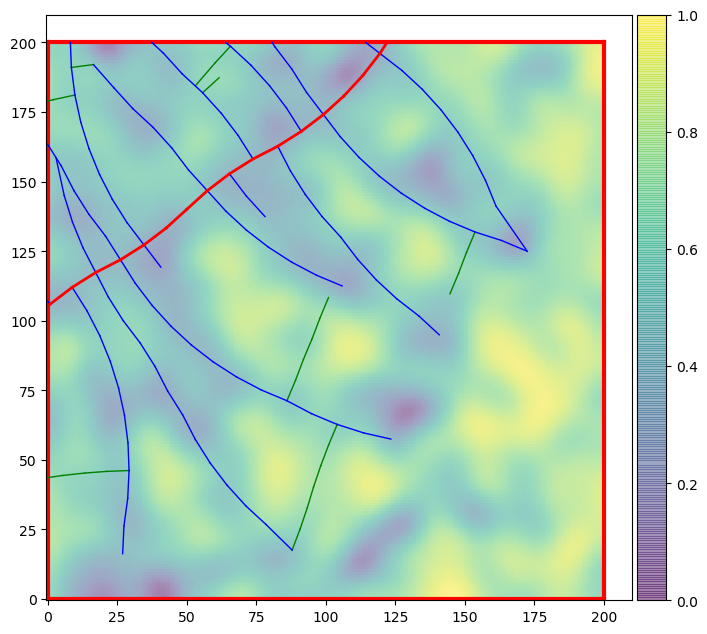

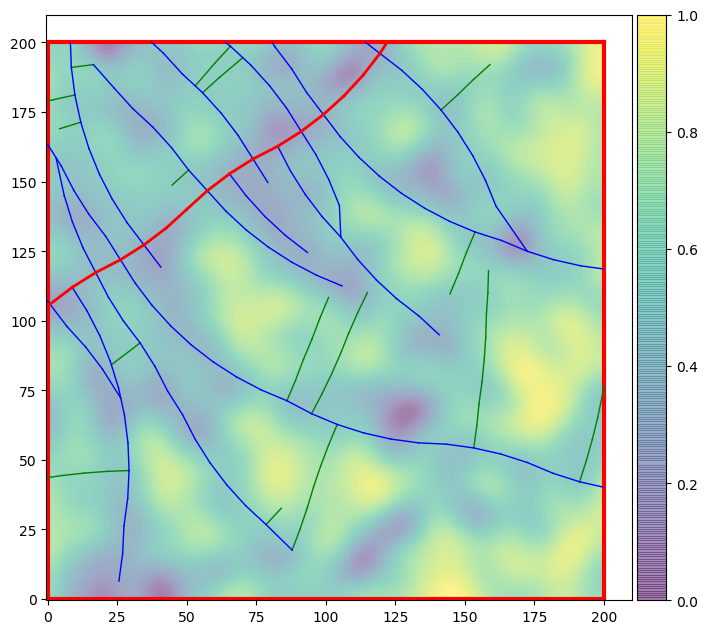

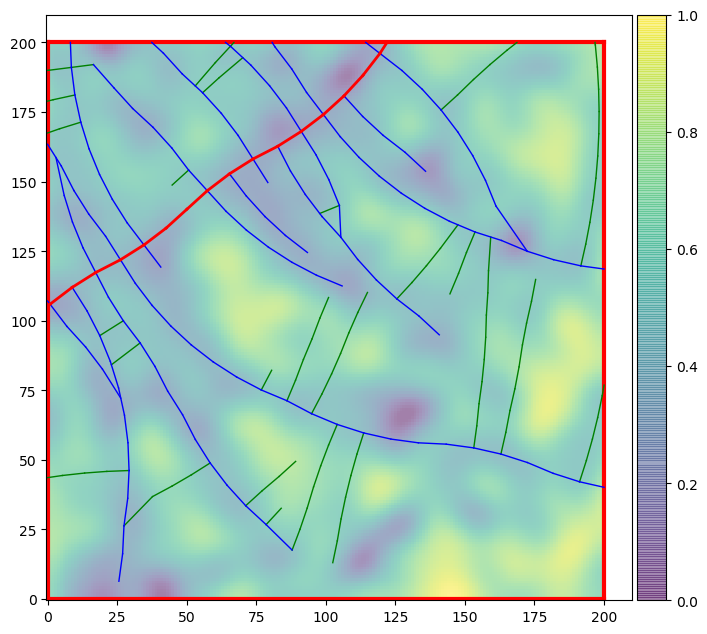

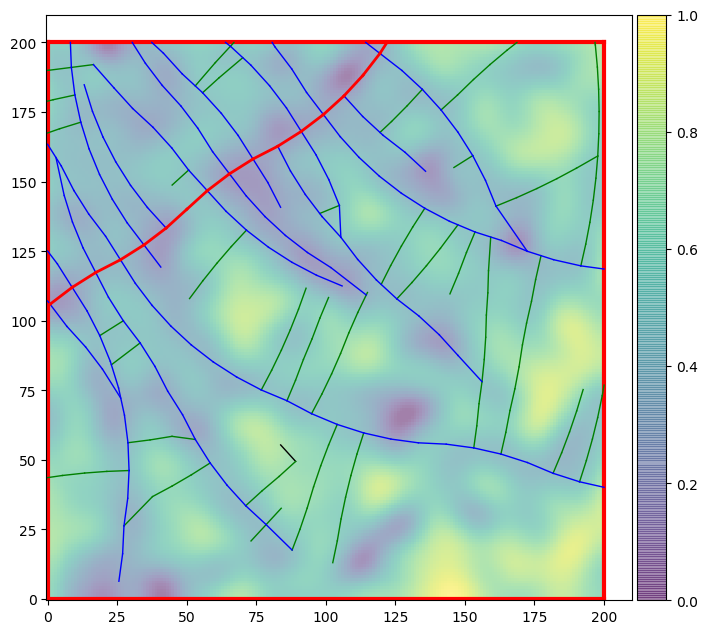

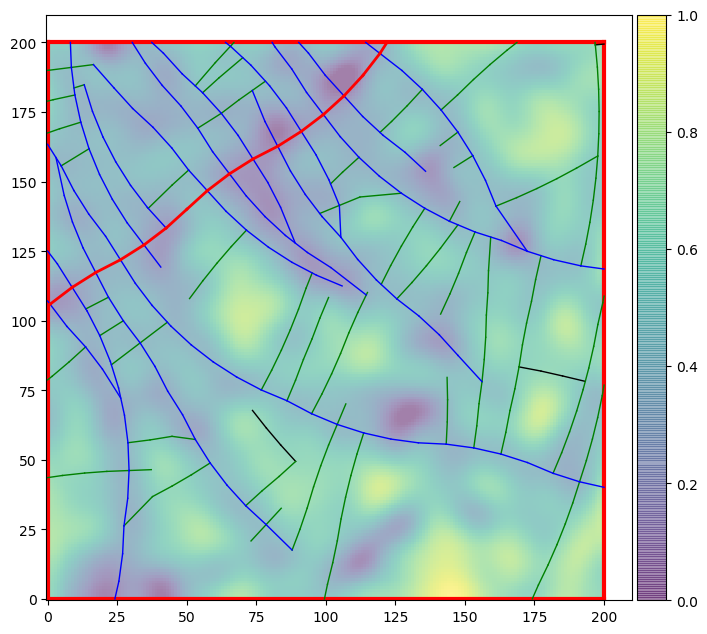

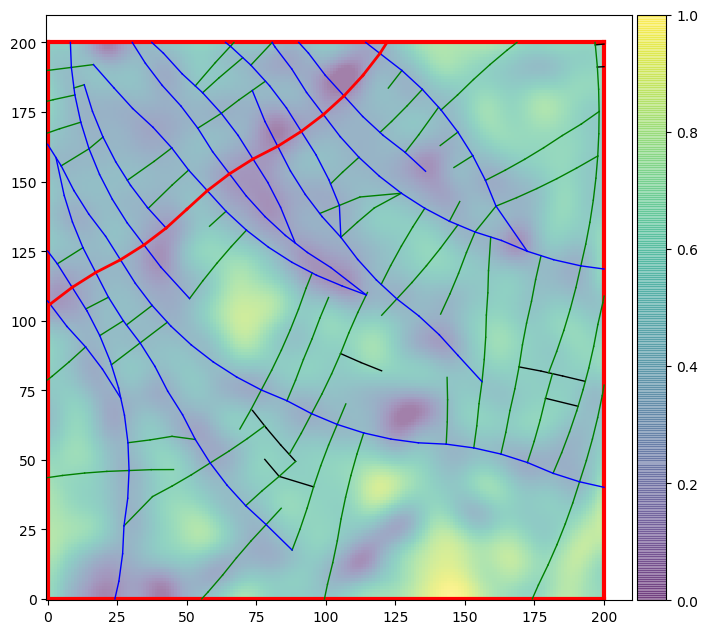

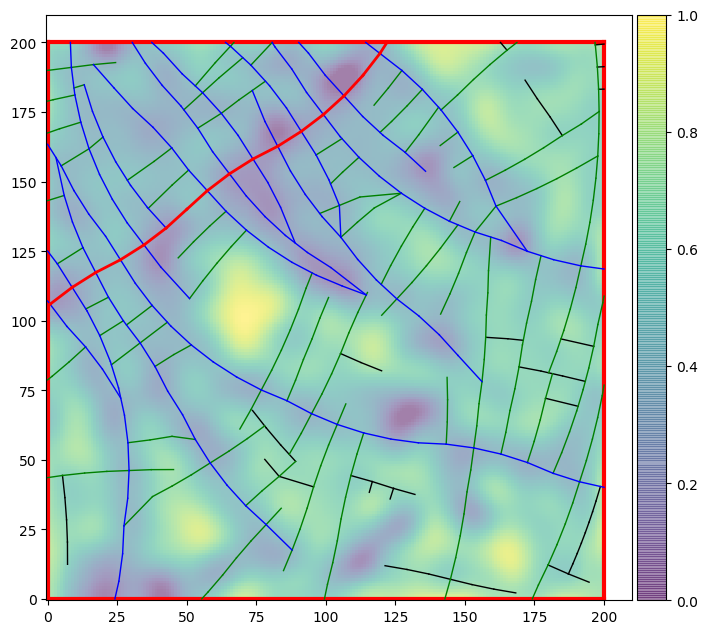

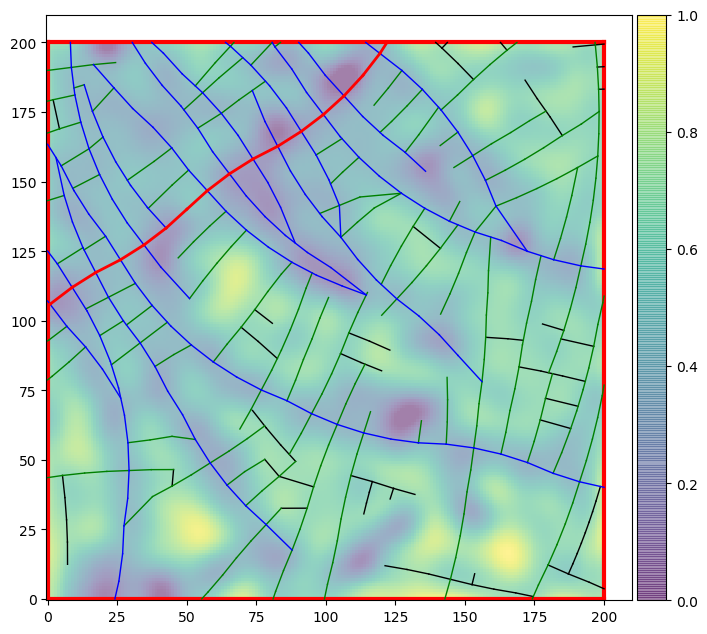

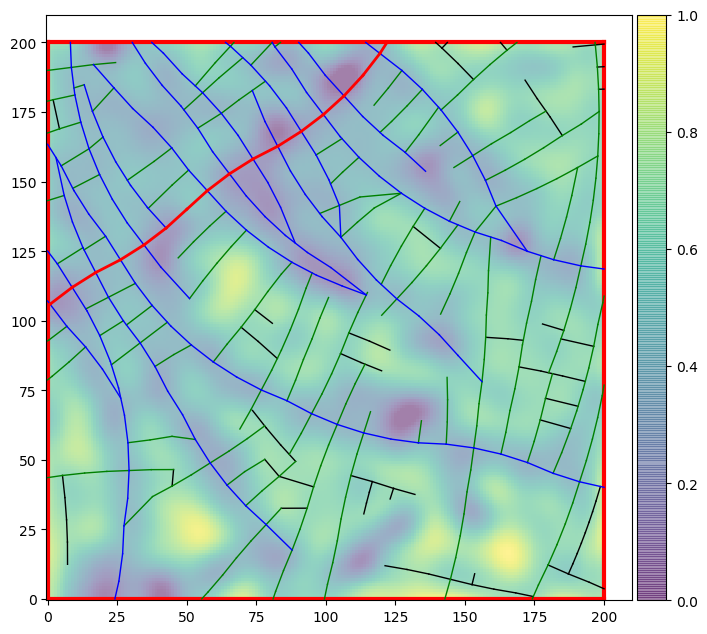

In [29]:
import numpy as np

class Capacitance:
    """ Population Density:
    Highways connect centers of population. To find the next population center, every highway road-end shoots
    a number of rays radially within a preset radius. Along this ray, samples of the population density are
    taken from the population density map. The population at every sample point on the ray is weighted with
    the inverse distance to the roadend and summed up. The direction with the largest sum is chosen for 
    continuing the growth.
    """

    def __init__(self, png='../examples/progressive_terrain/srtm1/N45W116.png'):
        #self.img = normalize(perlin(200, 100, 20, 1))
        self.img = normalize(perlin(200, 60, 2, 0.01))
        
        if png is not None:
            png = cv2.imread(png, cv2.IMREAD_GRAYSCALE)
            png = png / png.max()
            png = png[:200, :200]
            self.png = normalize(png)

            mask = np.zeros(self.png.shape)
            mask[np.where(self.png > 0.23)] += 1

            fps, _, _ = segment_regions(mask)
            itow = tform(vec3.O(), None, vec3(mask.shape[0], mask.shape[1], 0))
            self.fps = [itow.transform(fp) for fp in fps]
            
        else:
            mask = 1.0
        
        self.img *= mask
        
        #self.img = normalize(capacity)
        #self.img = capacity
        
    def __getitem__(self, u):        
        x = min(self.img.shape[1] - 1, int(u.x))
        y = min(self.img.shape[0] - 1, int(u.y))
        return x, y
        
    def point(self, u):
        x, y = self[u]
        return self.img[y, x]

    def edge(self, u, v):
        #return self.point(u.lerp(v, 0.5))
        return self.point(u) + self.point(v)

    def point_highway(self, u, v, a):
        raise
        
    def sink(self, u, d=1, sig=10):
        x_0, y_0 = self[u]
        x = np.arange(self.img.shape[0])
        y = np.arange(self.img.shape[1])
        x, y = np.meshgrid(x, y)
        self.img -= d * np.exp(-((x - x_0) ** 2 + (y - y_0) ** 2) / sig)
        self.img = np.clip(self.img, 0, 1)

    def grad(self, u):
        x, y = self[u]
        dx, dy = np.gradient(self.img)
        return vec3(dx[y, x], dy[y, x], 0)


class RoadSegment:

    def isnear(self, other):
        #return min(self.o.dxy(other.o), self.o.dxy(other.tip)) < (self.l + other.l)
        return min(self.o.dxy(other.o), self.o.dxy(other.tip)) < (self.l + self.l / 1.5)
    
    def __init__(self, o, d, l, a, layer, parent, max_turning_rate):
        self.o, self.d, self.l, self.a = o, d, l, a
        self.layer = layer
        self.parent = parent
        self.max_turning_rate = max_turning_rate

    def constrain_turning_rate(self):
        if self.parent is not None:            
            self_minor = bool((self.a / (np.pi / 2)) % 2)
            parent_minor = bool((self.parent.a / (np.pi / 2)) % 2)
            oriented = self_minor == parent_minor
            alpha = self.parent.d.ang(self.d)
            if oriented:
                if alpha > self.max_turning_rate:
                    z = np.sign(self.parent.d.crs(self.d).z)
                    if not z == 0:
                        self.d.rot(quat.av(alpha - self.max_turning_rate, vec3(0, 0, -z)))
            else:
                z = np.sign(self.parent.d.crs(self.d).z)
                z = 1 if z == 0 else z
                self.d = self.parent.d.cp()
                self.d.rot(quat.av(np.pi / 2, vec3(0, 0, -z)))
        assert not np.isnan(self.d.x)        
    
    def constrain_to_boundary(self, bounds, tip):
        # glue to boundary intersections
        ebnd, ibnds = bounds
        ips = []
        for u, v in slide(ebnd, 2):
            ip = sintsxyp(u, v, self.o, tip, 1, 1, 1, 1)
            if isinstance(ip, vec3):
                ips.append(ip)
            elif ip is not None:
                for i in ip:
                    ips.append(i)
        for ibnd in ibnds:
            for u, v in slide(ibnd, 2):
                ip = sintsxyp(u, v, self.o, tip, 1, 1, 1, 1)
                if isinstance(ip, vec3):
                    ips.append(ip)
                elif ip is not None:
                    for i in ip:
                        ips.append(i)
        ips = sorted(filter(None, ips), key=lambda ip: self.o.dxy(ip))
        tip = ips[0].cp() if ips else tip
        return tip
    
    def constrain(self, bounds, segments, debug=False):
        """enforce local contraints based on existing segments and boundaries"""

        self.constrain_turning_rate()
        
        tip = self.o + self.d * self.l
        eps = self.l / 1.5
        self.terminal = False

        tip = self.constrain_to_boundary(bounds, tip)

        relevant = [other for other in segments if self.isnear(other)]
        
        
        
        if False and debug:
            f, ax = plot()
            for seg in segments:
                plot_edge(ax, seg.o, seg.tip, col='r', lw=2)    
            for seg in relevant:
                plot_edge(ax, seg.o, seg.tip, col='y', lw=2)    
            plot_edge(ax, self.o, tip, col='b', lw=3)
        
        
        
        # glue to sufficiently nearby intersections
        ips = [sintsxyp(s.o, s.tip, self.o, tip + self.d * eps, 0, 0, 0, 1) for s in relevant]
        ips = sorted(filter(None, ips), key=lambda ip: self.o.dxy(ip))
        if ips:
            # if ip is not at u or v - split uv; flag for termination of growth
            tip = ips[0].cp()
            self.terminal = True
        
        # glue to sufficiently nearby crossings
        points = [s.o for s in relevant] + [s.tip for s in relevant]
        points = sorted(points, key=lambda p: p.dxy(tip))
        #points = sorted(points, key=lambda p: p.dexy(self.o.lerp(tip, 0.5), tip))
        #if points and points[0].dxy(tip) < eps:
        if points and points[0].dxy(tip + self.d * eps) < eps:
        #if points and points[0].dexy(self.o.lerp(tip, 0.5), tip) < eps:
            tip = points[0].cp()
            self.terminal = True
        else:
            crossing_tip = None
            
        self.tip = tip
        
        self.verify(relevant, eps)
        
    def verify(self, segments, eps):
        if self.tip.dxy(self.o) < 0.1:
            self.tip = None
            return
        for segment in segments:
            if segment.o.isnear(self.o, eps):
                alpha = (segment.tip - segment.o).ang(self.tip - self.o)
            elif segment.o.isnear(self.tip, eps):
                alpha = (segment.tip - segment.o).ang(self.o - self.tip)
            elif segment.tip.isnear(self.o, eps):
                alpha = (segment.o - segment.tip).ang(self.tip - self.o)
            elif segment.tip.isnear(self.o, eps):
                alpha = (segment.o - segment.tip).ang(self.o - self.tip)
            else:
                alpha = None
            if alpha is not None and alpha < np.pi / 4:
                self.tip = None
                return
            

class RoadNetwork:
    
    Z = vec3.Z()
    
    def __init__(self, config):
        self.config = config

    def init(self, bounds, root, png):
        self.bounds = bounds
        self.root = root
        self.population_fd = Capacitance(png)
        
        if hasattr(self.population_fd, 'fps'):
            self.bounds = (self.bounds[0], list(self.bounds[1]) + self.population_fd.fps)
        
        fd = self.population_fd.grad(self.root).nrm()
        fd = vec3.X() if fd.mag() == 0 else fd
        self.street_fd = vec3_field.grid(vec3.O(), fd.cp(), 0.0, 0.001)
        self.queue = [self.candidate(None, 0), self.candidate(None, 2)]
        self.segments = []

    def priority(self, segment):
        sl = self.config['switchlayer']
        score = self.population_fd.point(segment.o)
        score += max(0, sl - 0 - segment.layer) / (sl + 1)
        return score

    def candidate(self, parent=None, branch=0):
        tip = self.root if parent is None else parent.tip.cp()
        layer = 0 if parent is None else (parent.layer + abs(np.sign(branch)))
        alpha = (0 if parent is None else parent.a) + branch * np.pi / 2
        if layer <= self.config['switchlayer']:
            fd = self.population_fd.grad(tip)
        else:
            fd = self.street_fd(tip)
        cfg = self.config['layers'].get(layer, {})
        length, max_turn_rate = cfg.get('dl', 5), cfg.get('da', 0)
        tangent = fd.nrm().rot(quat.av(alpha, self.Z))
        segment = RoadSegment(tip, tangent, length, alpha, layer, parent, max_turn_rate)
        return segment
        
    def candidates(self, parent):
        queue = []
        if not (parent.terminal or parent.tip is None):
            if self.population_fd.point(parent.tip) > 0.03:
                queue.append(self.candidate(parent,  0))
                queue.append(self.candidate(parent, -1))
                queue.append(self.candidate(parent,  1))
        return queue
        
    def grow(self, bounds, root, max_segments, callback):
        self.init(bounds, root, None)
        self.pg = planargraph()
        with tqdm(total=max_segments) as pbar:
            while self.queue and len(self.segments) < max_segments:
                segment = self.queue.pop(0)
                segment.constrain(self.bounds, self.segments,
                                  debug=(len(self.segments) % (max_segments // 10) == 0))
                if segment.tip is not None:
                    i, j = self.pg.av(segment.o, 1, True), self.pg.av(segment.tip, 1, True)
                    if len(self.pg.rings[i]) < 4 and len(self.pg.rings[j]) < 4:
                        self.pg.ne(i, j, segment=segment)
                        self.segments.append(segment)
                        
                        sink_value = 0.02 if segment.layer <= 0 else 0.1
                        sig_value = segment.l * (20 if segment.layer <= 0 else 10)
                        
                        self.population_fd.sink(segment.o, d=sink_value, sig=sig_value)
                        self.population_fd.img = normalize(self.population_fd.img)
                        self.queue.extend(self.candidates(segment))
                        self.queue.sort(key=self.priority, reverse=True)
                        pbar.update(1)
                        if len(self.segments) % (max_segments // 10) == 0:
                            callback(self)
    
    def plot(self, ax, show_queue=False):
        colors = {0: 'r', 1: 'b', 2: 'g'}
        plot_loop(ax, self.bounds[0], col='r', lw=3)
        for b in self.bounds[1]:
            plot_loop(ax, b, col='r', lw=2)
        for seg in sorted(self.segments, key=lambda seg: seg.layer, reverse=True):
            col = colors.get(seg.layer, 'k')
            lw = 2 if seg.layer == 0 else 1
            plot_edge(ax, seg.o, seg.tip, col=col, lw=lw)    
        if show_queue:
            for seg in sorted(self.queue, key=lambda seg: seg.layer, reverse=True):
                col = 'y' if seg.layer == 0 else 'm'
                lw = 2 if seg.layer == 0 else 1
                seg.constrain_turning_rate()
                plot_edge(ax, seg.o, seg.o + seg.d * (seg.l / 4), col=col, lw=lw)
                

def grow_roads():    
    #x, y, z, u, v, w = 30, 30, 15, 15, 5, 5
    #x, y, z, u, v, w = 15, 15, 5, 5, 2, 2
    x, y, z, u, v, w = 5, 5, 2, 2, 1, 0
    #x, y, z = 2, 2, 0
    #x, y, z = 20, 5, 0
    #x, y, z = 30, 15, 5
    
    config = {
        'layers': {
        0: {'dl': 10, 'da': x * (np.pi / 180)},
        1: {'dl': 10, 'da': y * (np.pi / 180)},
        2: {'dl':  8, 'da': z * (np.pi / 180)},
        3: {'dl':  8, 'da': u * (np.pi / 180)},
        4: {'dl':  4, 'da': v * (np.pi / 180)},
        5: {'dl':  4, 'da': w * (np.pi / 180)},
            },
        'switchlayer': 3,
    }
    
    nx = RoadNetwork(config)
    
    bounds = (vec3(100, 100, 0).ring(100, 4, False), ())
    root = vec3(50, 140, 0)
    max_segments = 500

    def cb(nx):
        f, ax = plot()
        im = ax.imshow(nx.population_fd.img, origin='lower', alpha=0.5)
        nx.plot(ax)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        f.colorbar(im, cax=cax)
    
    nx.grow(bounds, root, max_segments, cb)

    cb(nx)
    
    return nx.pg, nx.bounds


f, ax = plot()
ax.imshow(Capacitance(None).img)

pg, bounds = grow_roads()